In [1]:
from typing import List, Dict, Any, Tuple, Optional, Self

import math, random, dataclasses, numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib.axes
from matplotlib.cm import get_cmap

plt.rcParams["figure.figsize"] = (6, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 11

# Structures de données et Visualisation

In [2]:
@dataclasses.dataclass
class Probleme:
    n: int  # Nombre de clients
    m: int  # Nombre de véhicules
    L: float  # Budget temps
    points: pd.DataFrame  # DataFrame des clients (x, y, score) => Pas une vraie donnée du problème TOP, mais utile pour afficher sur la carte
    # index du point de départ et du point d'arrivée (par défaut 0 et 1)
    start: int = 0
    end: int = 1
    # distance matrix stored as a numpy ndarray (shape n x n)
    dist_matrix: np.ndarray = dataclasses.field(init=False, repr=False)

    @classmethod
    def from_file(cls, filepath: str, start: int = 0, end: int = 0) -> Self:
        """Charge une instance à partir d'un fichier TSV attendu:\n première ligne: L <tab> m \n les lignes suivantes: x <tab> y <tab> score
        On peut passer `start` et `end` pour indiquer les indices des points de départ/arrivée dans les données.
        """
        metadata = pd.read_csv(filepath, sep=' ', nrows=3, header=None)
        points = pd.read_csv(filepath, sep='\t', skiprows=3, header=None)
        df = points.astype({0: float, 1: float, 2: int}).rename(columns={0: "x", 1: "y", 2: "score"})
        df = df.reset_index().rename(columns={'index': 'id'})
        return cls(
            n=df.shape[0],
            m=int(metadata.iloc[1, 1]),  # type: ignore
            L=float(metadata.iloc[2, 1]),  # type: ignore
            points=df,
            start=start,
            end=end,
        )

    def __post_init__(self):
        # compute Euclidean distances between points and store as numpy ndarray (shape n x n)
        pts = self.points[['x', 'y']].to_numpy()  # positional array, id == row index
        diffs = pts[:, None, :] - pts[None, :, :]
        mat = np.linalg.norm(diffs, axis=2)
        self.dist_matrix = mat  # numpy ndarray
        # Valider que start et end sont des indices valides [0, n-1]
        if not (0 <= self.start < self.n) or not (0 <= self.end < self.n):
            raise ValueError(f"Start ({self.start}) et End ({self.end}) doivent être des indices valides entre 0 et n-1")

    def scores_dict(self) -> Dict[int, int]:
        """Retourne un dict id -> score (utilise la colonne 'id' pour correspondre aux entiers)."""
        ids = self.ids()
        scores = self.points['score'].astype(int).tolist()
        return dict(zip(ids, scores))

    def ids(self) -> List[int]:
        return list(range(self.n))

    def plot(self, ax=None, title: Optional[str] = None) -> matplotlib.axes.Axes:
        """Affiche les points du problème sur `ax` (ou crée une figure).\n"""
        if ax is None:
            fig, ax = plt.subplots()
        pts = self.points
        ax.scatter(pts['x'], pts['y'], c='tab:blue', s=40, label='clients')
        # Annotate id and score next to chaque point
        for _, row in pts.iterrows():
            ax.text(row['x'] + 0.02, row['y'] + 0.02, f'id={int(row['id'])}, s={int(row['score'])}', fontsize=9)
        ax.set_title(title if title is not None else 'Instance')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.legend(loc='best')
        return ax


@dataclasses.dataclass
class Route:
    """Représente un cycle visitant une liste de points dans un problème donné et se connectant (implicitement) au point de départ à la fin."""
    stops: List[int]  # Indices (id column) des points visités en ordre
    probleme: Probleme  # Référence au problème associé pour calculer les métriques
    total_distance: float = 0.0
    total_score: int = 0
    used: bool = True  # NEW: whether this route is actually usable (fits budget)

    def __post_init__(self):
        self.compute_totals()
        
    def __copy__(self) -> "Route":
        new = object.__new__(Route)  # Avoid recomputing totals
        new.stops = list(self.stops)
        new.probleme = self.probleme
        # preserve the already-computed totals without recomputing
        new.total_distance = self.total_distance
        new.total_score = self.total_score
        new.used = self.used
        return new

    def compute_totals(self) -> None:
        pts_arr = self.probleme.points[['x', 'y', 'score']].to_numpy()
        if not self.stops:
            self.total_distance = 0.0
            self.total_score = 0
            self.used = False
            return

        coords = pts_arr[self.stops, :2]
        dists = np.linalg.norm(coords[1:] - coords[:-1], axis=1) if len(coords) > 1 else np.array([], dtype=float)
        total = float(dists.sum())

        # Fermer uniquement si on est en mode dépôt unique (start == end)
        if self.probleme.start == self.probleme.end and len(coords) > 1:
            total += float(np.linalg.norm(coords[0] - coords[-1]))

        # Si uniquement [start, end] et que la liaison dépasse L -> unused
        if len(self.stops) == 2 and total > self.probleme.L + 1e-9:
            self.total_distance = 0.0
            self.total_score = 0
            self.used = False
            return

        self.total_distance = total
        self.total_score = int(pts_arr[self.stops, 2].sum())
        self.used = True

    def __add__(self, other: int) -> 'Route':
        """Retourne une NOUVELLE Route avec `other` ajouté à la fin.
        Raise si l'opération créerait une route au-delà du budget (devrait être évitée par les heuristiques).
        """
        if other in self.stops:
            raise ValueError("Stop already in route")
        new_stops = list(self.stops) + [other]
        # create candidate to compute totals; if it exceeds budget, raise
        cand = Route(new_stops, self.probleme)
        if cand.total_distance > self.probleme.L + 1e-9:
            raise ValueError(f"Adding stop {other} would exceed budget L={self.probleme.L} (distance={cand.total_distance:.6f})")
        return cand

    def __remove__(self, other: int) -> 'Route':
        """Retourne une NOUVELLE Route sans l'arrêt `other`."""
        if other not in self.stops:
            raise ValueError("Stop not in route")
        new_stops = [s for s in self.stops if s != other]
        return Route(new_stops, self.probleme)

    def plot(self, ax=None, color='tab:orange', label: Optional[str] = None) -> matplotlib.axes.Axes:
        """Dessine la route sur `ax` (crée `ax` si None)."""
        if ax is None:
            fig, ax = plt.subplots()
        if not self.stops:
            return ax
        coords = self.probleme.points[['x', 'y']].to_numpy()[self.stops]
        # pour tracer le cycle, ajouter le premier point à la fin
        if len(coords) > 1:
            closed = np.vstack([coords, coords[0]])
        else:
            closed = coords
        # plot polyline (cycle)
        ax.plot(closed[:, 0], closed[:, 1], '-o', c=color, lw=2, label=(label if label else 'route'))
        # annotate stops with order
        for idx, sid in enumerate(self.stops):
            row = self.probleme.points.iloc[sid]
            ax.text(row['x'] + 0.02, row['y'] + 0.02, str(idx), color=color, fontsize=9)  # type: ignore : types de colonnes pandas non vérifiés
        return ax

# Recherche d'une solution initiale

In [3]:
def simple_greedy_routes(prob: Probleme, seed: Optional[int] = None, snapshot_every: int = 0) -> Tuple[List[Route], List[List[Route]]]:
    """Construction gloutonne (insertion séquentielle) adaptée au TOP.
    Les routes sont initialisées comme [start, end] et on insère des clients entre des paires
    consécutives (pos, pos+1). On utilise `prob.dist_matrix` (numpy) pour calculer delta de coût.
    Retourne (routes, snapshots).
    """
    # ids is a simple numeric range; do not rely on pandas index labels
    ids = prob.ids()
    scores = prob.scores_dict()
    # On ne sert pas start/end
    unserved = set(ids) - {prob.start, prob.end}
    routes: List[Route] = [Route([prob.start, prob.end], prob) for _ in range(prob.m)]
    snapshots: List[List[Route]] = []
    inserted = 0

    # insertion: pour chaque route, pour chaque position entre stops[pos] and stops[pos+1],
    # calculer delta = dist(i,u) + dist(u,j) - dist(i,j) using numpy dist_matrix
    while True:
        best = None  # tuple (ratio, r_idx, pos, u, delta)
        for r_idx, r in enumerate(routes):
            for pos in range(len(r.stops) - 1):
                i = r.stops[pos]
                j = r.stops[pos + 1]
                for u in list(unserved):
                    dlt = float(prob.dist_matrix[i, u] + prob.dist_matrix[u, j] - prob.dist_matrix[i, j])
                    new_cost = r.total_distance + dlt
                    if new_cost <= prob.L + 1e-9:
                        ratio = scores[u] / (dlt if dlt > 1e-9 else 1e-9)
                        if best is None or ratio > best[0]:
                            best = (ratio, r_idx, pos, u, dlt)
        if best is None:
            break
        _, r_idx, pos, u, dlt = best
        # perform insertion
        new_stops = list(routes[r_idx].stops)
        new_stops.insert(pos + 1, u)
        routes[r_idx] = Route(new_stops, prob)
        unserved.remove(u)
        inserted += 1
        if snapshot_every and (inserted % snapshot_every == 0):
            snapshots.append(routes.copy())
            
    return routes, snapshots

def polar_sweep_routes(prob: Probleme, max_routes: Optional[int] = None) -> List[Route]:
    """Heuristique 'Gillet & Miller' (balayage angulaire).
    - Classe les clients par angle polaire autour du dépôt (start).
    - Balaye l'angle et constitue des routes séquentielles en insérant le plus proche possible
      tant que la contrainte de longueur prob.L n'est pas violée.
    Justification : exploite la structure géométrique locale (bon pour dépôts centraux)."""
    if max_routes is None:
        max_routes = prob.m
    start_xy = prob.points.loc[prob.start, ['x', 'y']].to_numpy()
    ids = [i for i in prob.ids() if i not in (prob.start, prob.end)]
    # compute angles
    pts = prob.points[['x', 'y']].to_numpy()
    rel = pts[ids] - start_xy[None, :]
    angles = np.arctan2(rel[:,1], rel[:,0])
    order = [ids[i] for i in np.argsort(angles)]

    routes: List[Route] = []
    current = Route([prob.start, prob.end], prob)
    for u in order:
        # try cheapest insertion into current route
        best_pos = None
        best_dlt = None
        for pos in range(len(current.stops)-1):
            i = current.stops[pos]; j = current.stops[pos+1]
            dlt = float(prob.dist_matrix[i,u] + prob.dist_matrix[u,j] - prob.dist_matrix[i,j])
            if current.total_distance + dlt <= prob.L + 1e-9:
                if best_pos is None or dlt < best_dlt:
                    best_pos = pos; best_dlt = dlt
        if best_pos is not None:
            new_stops = list(current.stops); new_stops.insert(best_pos+1, u)
            current = Route(new_stops, prob)
        else:
            # close current route and start a new one if allowed
            routes.append(current)
            if len(routes) >= max_routes:
                # remaining clients are left unserved
                current = Route([prob.start, prob.end], prob)
                break
            current = Route([prob.start, prob.end], prob)
            # try insert u into fresh route (if fits)
            i = current.stops[0]; j = current.stops[1]
            dlt = float(prob.dist_matrix[i,u] + prob.dist_matrix[u,j] - prob.dist_matrix[i,j])
            if dlt + current.total_distance <= prob.L + 1e-9:
                current = Route([prob.start, u, prob.end], prob)
    routes.append(current)
    # pad with empty routes if needed
    while len(routes) < prob.m:
        routes.append(Route([prob.start, prob.end], prob))
    return routes

def clarke_wright_marguerite(prob: Probleme, limit_routes: Optional[int] = None) -> List[Route]:
    """Heuristique de Clarke & Wright (marguerite) - version simple.
    - Initialise une route par client: [start, u, end].
    - Calcule les 'savings' s(u,v) = d(s,u)+d(v,s)-d(u,v) et les trie décroissants.
    - Tente de fusionner deux routes quand les extrémités sont compatibles et que la fusion
      respecte la limite de longueur prob.L.
    Justification : méthode parallèle classique, minimise coût et nombre de routes."""
    if limit_routes is None:
        limit_routes = prob.m
    ids = [i for i in prob.ids() if i not in (prob.start, prob.end)]
    # start with one-route-per-client
    routes = {u: Route([prob.start, u, prob.end], prob) for u in ids}
    # compute savings
    savings = []
    for i_idx, u in enumerate(ids):
        for v in ids[i_idx+1:]:
            s = float(prob.dist_matrix[prob.start, u] + prob.dist_matrix[v, prob.start] - prob.dist_matrix[u, v])
            savings.append((s, u, v))
    savings.sort(reverse=True, key=lambda x: x[0])

    for s, u, v in savings:
        # check routes still exist and are distinct
        if u not in routes or v not in routes or u == v:
            continue
        ru = routes[u]; rv = routes[v]
        if ru is rv:
            continue
        # ru: ... u ] , rv: [ v ... => try to connect tail of ru to head of rv
        if ru.stops[-2] == u and rv.stops[1] == v:
            candidate_stops = ru.stops[:-1] + rv.stops[1:]
            cand = Route(candidate_stops, prob)
            if cand.total_distance <= prob.L + 1e-9:
                # merge: remove all keys pointing to ru and rv and add new representative
                # use first client in merged route as key
                merged_clients = [x for x in cand.stops if x not in (prob.start, prob.end)]
                # remove old entries
                for x in list(routes.keys()):
                    if routes[x] is ru or routes[x] is rv:
                        del routes[x]
                # register merged route under its clients
                for x in merged_clients:
                    routes[x] = cand
        # stop early if enough routes
        unique_routes = {id(r) : r for r in routes.values()}.values()
        if len(list(unique_routes)) <= limit_routes:
            break
    # return up to prob.m routes (unique objects)
    uniq = list({id(r): r for r in routes.values()}.values())
    # pad
    while len(uniq) < prob.m:
        uniq.append(Route([prob.start, prob.end], prob))
    return uniq[:prob.m]

def randomized_greedy_routes(prob: Probleme, alpha: float = 0.2, seed: Optional[int] = None, restarts: int = 10) -> List[Route]:
    """GRASP-like randomized construction with multiple restarts.
    Runs up to `restarts` independent randomized constructions and returns the best
    set of routes (best total score, tie-broken by total distance).
    """
    if restarts <= 0:
        restarts = 1
    best_routes: Optional[List[Route]] = None
    best_score = -1
    best_total_dist = float("inf")
    base_seed = seed if seed is not None else None

    for r in range(restarts):
        # control randomness for reproducibility if seed given
        if base_seed is not None:
            random.seed(base_seed + r)
        else:
            random.seed(None)

        ids = prob.ids()
        scores = prob.scores_dict()
        unserved = set(ids) - {prob.start, prob.end}
        routes: List[Route] = [Route([prob.start, prob.end], prob) for _ in range(prob.m)]

        # construction phase (same logic as before)
        while True:
            candidates = []  # (score_ratio, r_idx, pos, u, dlt)
            for r_idx, rt in enumerate(routes):
                for pos in range(len(rt.stops) - 1):
                    i = rt.stops[pos]; j = rt.stops[pos + 1]
                    for u in list(unserved):
                        dlt = float(prob.dist_matrix[i, u] + prob.dist_matrix[u, j] - prob.dist_matrix[i, j])
                        if rt.total_distance + dlt <= prob.L + 1e-9:
                            ratio = scores[u] / (dlt if dlt > 1e-9 else 1e-9)
                            candidates.append((ratio, r_idx, pos, u, dlt))
            if not candidates:
                break
            candidates.sort(reverse=True, key=lambda x: x[0])
            k = max(1, int(len(candidates) * alpha))
            chosen = random.choice(candidates[:k])
            _, r_idx, pos, u, dlt = chosen
            new_stops = list(routes[r_idx].stops); new_stops.insert(pos + 1, u)
            routes[r_idx] = Route(new_stops, prob)
            unserved.remove(u)

        # evaluate solution
        total_score = sum(rt.total_score for rt in routes)
        total_dist = sum(rt.total_distance for rt in routes)
        # keep best by score, tie-break by distance
        if (total_score > best_score) or (total_score == best_score and total_dist < best_total_dist):
            best_score = total_score
            best_total_dist = total_dist
            best_routes = routes

    # best_routes is never None because restarts >= 1
    return best_routes if best_routes is not None else [Route([prob.start, prob.end], prob) for _ in range(prob.m)]

# Amélioration d'une solution (rechrche locale)

In [4]:
def three_opt_route(route: Route, max_iter: int = 200) -> Route:
    """Simple 3-opt style reconnection on a single Route. Returns a NEW Route.
    Acceptance criterion: keep candidate if feasible (<= L) and not worse on score, tie-breaker on shorter distance.
    This is a modest (and safe) enumeration of a few common 3-opt reconnections.
    """
    best = Route(list(route.stops), route.probleme)
    n = len(best.stops)
    if n < 5:  # need at least 3 internal nodes to make 3-opt interesting
        return best
    it = 0
    improved = True
    while improved and it < max_iter:
        it += 1
        improved = False
        for i in range(1, n - 3):
            for j in range(i + 1, n - 2):
                for k in range(j + 1, n - 1):
                    # split into segments A | B | C | D
                    S = best.stops
                    A = S[:i]; B = S[i:j]; C = S[j:k]; D = S[k:]
                    candidates = []
                    # a set of typical reconnections (non-exhaustive)
                    candidates.append(A + list(reversed(B)) + C + D)    # reverse B
                    candidates.append(A + B + list(reversed(C)) + D)    # reverse C
                    candidates.append(A + list(reversed(B)) + list(reversed(C)) + D)  # reverse B and C
                    candidates.append(A + C + B + D)  # swap B and C
                    candidates.append(A + list(reversed(C)) + B + D)  # reverse C then swap
                    for new_stops in candidates:
                        cand = Route(new_stops, route.probleme)
                        if cand.total_distance <= route.probleme.L + 1e-9:
                            # prefer higher score, then shorter distance
                            if (cand.total_score > best.total_score) or (cand.total_score == best.total_score and cand.total_distance + 1e-9 < best.total_distance):
                                best = cand
                                improved = True
                                break
                    if improved:
                        break
                if improved:
                    break
            if improved:
                break
    return best

def three_opt_each_routes(routes: List[Route], metaparams: Optional[Dict[str, Any]] = None) -> List[Route]:
    """Apply three_opt_route to each route and return a new list of routes."""
    return [three_opt_route(r, max_iter=200) for r in routes]

def replace_node_with_unvisited(routes: List[Route], metaparams: Optional[Dict[str, Any]] = None) -> List[Route]:
    """Try replacing a visited node by an unvisited node (from metaparams['unvisited'] or computed).
    Keeps best single replacement that increases total score (tie-break shorter distances).
    """
    if not routes: return routes
    prob = routes[0].probleme
    # compute unvisited set if not provided
    if metaparams is None: metaparams = {}
    provided = metaparams.get('unvisited', None)
    if provided is None:
        visited = set()
        for r in routes:
            visited.update([s for s in r.stops if s not in (prob.start, prob.end)])
        unvisited = [u for u in prob.ids() if u not in visited and u not in (prob.start, prob.end)]
    else:
        unvisited = [u for u in provided if u not in (prob.start, prob.end)]
    best_gain = 0.0; best_move = None
    for ri, r in enumerate(routes):
        for pos in range(1, len(r.stops) - 1):
            orig = r.stops[pos]
            for u in unvisited:
                if u == orig: continue
                new_stops = list(r.stops); new_stops[pos] = u
                cand = Route(new_stops, prob)
                if cand.total_distance <= prob.L + 1e-9:
                    gain = cand.total_score - r.total_score
                    # prefer positive gains, tie-break distance decrease
                    if gain > best_gain + 1e-9 or (abs(gain - best_gain) <= 1e-9 and cand.total_distance + 1e-9 < routes[ri].total_distance):
                        best_gain = gain; best_move = (ri, pos, u, cand)
    if best_move is not None and best_gain >= -1e-9:
        ri, pos, u, cand = best_move
        new_routes = [Route(list(r.stops), r.probleme) for r in routes]
        new_routes[ri] = cand
        return new_routes
    return routes

def insert_unvisited_into_routes(routes: List[Route], metaparams: Optional[Dict[str, Any]] = None) -> List[Route]:
    """Try inserting an unvisited node into any route/position. Keep best single insertion that increases score.
    metaparams['unvisited'] may provide candidate nodes; otherwise they are computed from prob.
    """
    if not routes: return routes
    prob = routes[0].probleme
    if metaparams is None: metaparams = {}
    provided = metaparams.get('unvisited', None)
    if provided is None:
        visited = set()
        for r in routes:
            visited.update([s for s in r.stops if s not in (prob.start, prob.end)])
        unvisited = [u for u in prob.ids() if u not in visited and u not in (prob.start, prob.end)]
    else:
        unvisited = [u for u in provided if u not in (prob.start, prob.end)]
    best_gain = 0.0; best_move = None
    for u in unvisited:
        for ri, r in enumerate(routes):
            for pos in range(0, len(r.stops) - 1):
                new_stops = list(r.stops); new_stops.insert(pos + 1, u)
                cand = Route(new_stops, prob)
                if cand.total_distance <= prob.L + 1e-9:
                    gain = cand.total_score - r.total_score
                    if gain > best_gain + 1e-9 or (abs(gain - best_gain) <= 1e-9 and cand.total_distance + 1e-9 < r.total_distance):
                        best_gain = gain; best_move = (ri, pos, u, cand)
    if best_move is not None and best_gain >= -1e-9:
        ri, pos, u, cand = best_move
        new_routes = [Route(list(r.stops), r.probleme) for r in routes]
        new_routes[ri] = cand
        return new_routes
    return routes

def two_opt_route(route: Route, max_iter: int = 1000) -> Route:
    """Amélioration locale 2-opt sur une Route (retourne une NOUVELLE Route améliorée).
    On respecte la contrainte de longueur `route.probleme.L`: toute modification doit garder total_distance <= prob.L.
    Les extrémités (start / end) sont conservées.
    """
    best = Route(list(route.stops), route.probleme)
    n = len(best.stops)
    if n < 4:  # moins de 2 arêtes internes -> rien à inverser
        return best
    improved = True
    it = 0
    while improved and it < max_iter:
        improved = False
        it += 1
        for i in range(1, n - 2):  # ne pas toucher l'indice 0 (start)
            for j in range(i + 1, n - 1):  # ne pas toucher l'indice n-1 (end)
                # créer une nouvelle permutation en inversant le segment i..j
                new_stops = best.stops[:i] + list(reversed(best.stops[i:j+1])) + best.stops[j+1:]
                candidate = Route(new_stops, route.probleme)
                # accepter si amélioration (réduction de distance) et toujours faisable
                if candidate.total_distance + 1e-9 < best.total_distance and candidate.total_distance <= route.probleme.L + 1e-9:
                    best = candidate
                    improved = True
                    break
            if improved:
                break
    return best

def two_opt_each_routes(routes: List[Route], max_iter: int = 1000) -> List[Route]:
    """Applique 2-opt localement sur chaque route de la liste `routes`.
    Retourne une NOUVELLE liste de routes améliorées."""
    new_routes = []
    for r in routes:
        improved_route = two_opt_route(r, max_iter=max_iter)
        new_routes.append(improved_route)
    return new_routes

def swap_between_routes(routes: List[Route]) -> List[Route]:
    """Swap simple entre routes : échange de deux noeuds (excluant start/end) appartenant à deux routes.
    - Parcourt toutes les paires (r1,r2) et tous les clients i in r1, j in r2 et teste l'échange.
    - Accepte l'échange qui augmente la somme des scores et respecte prob.L pour les deux routes.
    Justification : opérateur basique (Swap) pour VRP/TOP; explore voisinage inter-routes."""
    # obtain problem from first route
    if not routes: return routes
    prob = routes[0].probleme
    best_gain = 0
    best_move = None
    for a in range(len(routes)):
        for b in range(a+1, len(routes)):
            r1 = routes[a]; r2 = routes[b]
            for i_pos in range(1, len(r1.stops)-1):
                for j_pos in range(1, len(r2.stops)-1):
                    i = r1.stops[i_pos]; j = r2.stops[j_pos]
                    new_r1_stops = list(r1.stops); new_r1_stops[i_pos] = j
                    new_r2_stops = list(r2.stops); new_r2_stops[j_pos] = i
                    cand1 = Route(new_r1_stops, prob); cand2 = Route(new_r2_stops, prob)
                    if cand1.total_distance <= prob.L + 1e-9 and cand2.total_distance <= prob.L + 1e-9:
                        gain = (cand1.total_score + cand2.total_score) - (r1.total_score + r2.total_score)
                        if gain > best_gain + 1e-9:
                            best_gain = gain
                            best_move = (a, i_pos, b, j_pos, cand1, cand2)
    if best_move is not None:
        a, i_pos, b, j_pos, cand1, cand2 = best_move
        routes[a] = cand1; routes[b] = cand2
    return routes

def or_opt_between_routes(routes: List[Route], k: int = 2) -> List[Route]:
    """Or-Opt inter-routes : extrait une chaîne de longueur k d'une route et tente de l'insérer
    telle quelle dans une autre route (toutes positions). On accepte si la somme des scores augmente
    et si les deux routes restent faisables (<= prob.L)."""
    if not routes: return routes
    prob = routes[0].probleme
    best_gain = 0; best_move = None
    for a in range(len(routes)):
        for b in range(len(routes)):
            if a == b: continue
            rA = routes[a]; rB = routes[b]
            for i in range(1, max(1, len(rA.stops)-k)):
                segment = rA.stops[i:i+k]
                if len(segment) < k: continue
                # new A without segment
                newA = rA.stops[:i] + rA.stops[i+k:]
                for pos in range(1, len(rB.stops)):
                    newB = list(rB.stops[:pos]) + segment + list(rB.stops[pos:])
                    candA = Route(newA, prob); candB = Route(newB, prob)
                    if candA.total_distance <= prob.L + 1e-9 and candB.total_distance <= prob.L + 1e-9:
                        gain = (candA.total_score + candB.total_score) - (rA.total_score + rB.total_score)
                        if gain > best_gain + 1e-9:
                            best_gain = gain; best_move = (a, b, i, k, pos, candA, candB)
    if best_move is not None:
        a, b, i, k, pos, candA, candB = best_move
        routes[a] = candA; routes[b] = candB
    return routes

def cross_exchange(routes: List[Route]) -> List[Route]:
    """Cross-exchange simple : échange deux suffixes (ou préfixes) entre deux routes.
    - Pour chaque paire de routes, teste échange de segments r1[i:] <-> r2[j:], vérifie faisabilité
      et accepte si le score total augmente.
    Justification : opérateur de 'string exchange' simplifié pour diversification."""
    if not routes: return routes
    prob = routes[0].probleme
    best_gain = 0; best_move = None
    for a in range(len(routes)):
        for b in range(a+1, len(routes)):
            r1 = routes[a]; r2 = routes[b]
            for i in range(1, len(r1.stops)-1):
                for j in range(1, len(r2.stops)-1):
                    new1 = r1.stops[:i] + r2.stops[j:]
                    new2 = r2.stops[:j] + r1.stops[i:]
                    cand1 = Route(new1, prob); cand2 = Route(new2, prob)
                    if cand1.total_distance <= prob.L + 1e-9 and cand2.total_distance <= prob.L + 1e-9:
                        gain = (cand1.total_score + cand2.total_score) - (r1.total_score + r2.total_score)
                        if gain > best_gain + 1e-9:
                            best_gain = gain; best_move = (a, b, cand1, cand2)
    if best_move is not None:
        a, b, cand1, cand2 = best_move
        routes[a] = cand1; routes[b] = cand2
    return routes

def or_opt_within_routes(routes: List[Route], max_k: int = 3) -> List[Route]:
    """Intra-route Or-Opt: extract a segment of length k from a route and reinsert it elsewhere inside the same route.
    Accepts any move that increases total score (prefer) or decreases total distance while respecting L.
    Returns new routes list (copy)."""
    if not routes: return routes
    prob = routes[0].probleme
    new_routes = [Route(list(r.stops), r.probleme) for r in routes]
    for idx, r in enumerate(routes):
        best_move = None
        n = len(r.stops)
        for k in range(1, min(max_k, n-2) + 1):
            for i in range(1, n - k):
                segment = r.stops[i:i+k]
                rem = r.stops[:i] + r.stops[i+k:]
                for pos in range(1, len(rem)):
                    if pos == i: continue
                    cand = Route(rem[:pos] + segment + rem[pos:], prob)
                    if cand.total_distance <= prob.L + 1e-9:
                        gain = cand.total_score - r.total_score
                        score = (gain, r.total_distance - cand.total_distance)
                        if best_move is None or score > best_move[0]:
                            best_move = (score, cand)
        if best_move is not None and (best_move[0][0] >= 0 or best_move[0][1] > 1e-9):
            new_routes[idx] = best_move[1]
    return new_routes

def relocate_between_routes(routes: List[Route]) -> List[Route]:
    """Move a single node from one route to another (all positions). Accepts only if both routes feasible and
    total score is not decreased (prefer increases). Returns modified list if improvement found (best one)."""
    if not routes: return routes
    prob = routes[0].probleme
    best_gain = 0; best_move = None
    for a in range(len(routes)):
        for b in range(len(routes)):
            if a == b: continue
            rA = routes[a]; rB = routes[b]
            for i_pos in range(1, len(rA.stops)-1):
                node = rA.stops[i_pos]
                newA = rA.stops[:i_pos] + rA.stops[i_pos+1:]
                for pos in range(1, len(rB.stops)):
                    newB = rB.stops[:pos] + [node] + rB.stops[pos:]
                    candA = Route(newA, prob); candB = Route(newB, prob)
                    if candA.total_distance <= prob.L + 1e-9 and candB.total_distance <= prob.L + 1e-9:
                        gain = (candA.total_score + candB.total_score) - (rA.total_score + rB.total_score)
                        if gain > best_gain + 1e-9:
                            best_gain = gain; best_move = (a, b, i_pos, pos, candA, candB)
    if best_move is not None:
        a, b, i_pos, pos, candA, candB = best_move
        routes[a] = candA; routes[b] = candB
    return routes

def relocate_within_routes(routes: List[Route]) -> List[Route]:
    """Move a single node inside the same route (reinsertion). Return improved routes if found."""
    if not routes: return routes
    prob = routes[0].probleme
    new_routes = [Route(list(r.stops), r.probleme) for r in routes]
    for idx, r in enumerate(routes):
        best_gain = 0; best_cand = None
        for i in range(1, len(r.stops)-1):
            node = r.stops[i]
            rem = r.stops[:i] + r.stops[i+1:]
            for pos in range(1, len(rem)):
                cand = Route(rem[:pos] + [node] + rem[pos:], prob)
                if cand.total_distance <= prob.L + 1e-9:
                    gain = cand.total_score - r.total_score
                    # also accept distance-improving moves
                    if gain > best_gain + 1e-9 or (gain >= -1e-9 and cand.total_distance + 1e-9 < r.total_distance):
                        best_gain = gain; best_cand = cand
        if best_cand is not None:
            new_routes[idx] = best_cand
    return new_routes

def iterated_local_search(routes: List[Route], max_iter: int = 5) -> List[Route]:
    """Apply a fixed sequence of operators iteratively until no improvement or max_iter reached.
    metaparams can contain 'max_iter' (default 5) and order/list of operators (optional)."""
    if not routes: return routes
    prob = routes[0].probleme
    # default pipeline (can be overridden via metaparams['pipeline'])
    pipeline = [
        two_opt_each_routes,
        lambda rs: or_opt_within_routes(rs, max_k=3),
        relocate_within_routes,
        relocate_between_routes,
        swap_between_routes,
        lambda rs: or_opt_between_routes(rs, k=2),
        cross_exchange,
    ]
    current = [Route(list(r.stops), r.probleme) for r in routes]
    it = 0
    while it < max_iter:
        it += 1
        prev_score = sum(r.total_score for r in current)
        for op in pipeline:
            current = op(current)
        new_score = sum(r.total_score for r in current)
        if new_score <= prev_score + 1e-9:
            break
    return current

In [5]:
def _total_score(routes): 
    return sum(r.total_score for r in routes)

def _deepcopy_routes(routes):
    # fige l'état (évite que les snapshots “bougent” plus tard)
    return [Route(list(r.stops), r.probleme) for r in routes]

def improve_travel_time(routes):
    """
    Phase 'compression': réduit la distance sans changer l'ensemble de clients.
    On combine quelques opérateurs rapides et sûrs.
    """
    routes = two_opt_each_routes(routes, max_iter=300)
    routes = or_opt_within_routes(routes, max_k=3)
    routes = relocate_within_routes(routes)
    # Un peu d'inter-routes pour débloquer des reconfigurations
    routes = swap_between_routes(routes)
    routes = or_opt_between_routes(routes, k=2)
    routes = cross_exchange(routes)
    routes = relocate_between_routes(routes)
    return routes

def expand_with_unvisited(routes, max_insertions=10, reopt_each_insert=True):
    """
    Phase 'extension': on tente d'ajouter autant de non-visités que possible.
    - On itère des insertions gloutonnes; optionnellement, on re-optimise vite
      après chaque insertion pour re-libérer du budget et enchaîner d'autres insertions.
    - Ensuite on essaie des 'remplacements' si cela augmente le score.
    Retourne les routes (éventuellement inchangées si rien n'est possible).
    """
    # 1) Chaîne d’insertions jusqu'à blocage
    inserted = 0
    while inserted < max_insertions:
        new_routes = insert_unvisited_into_routes(routes)
        if new_routes is routes:  # aucune insertion réalisable
            break
        routes = new_routes
        inserted += 1
        # petit reopt pour regagner du budget si demandé
        if reopt_each_insert:
            routes = two_opt_each_routes(routes, max_iter=150)

    # 2) Remplacements (si on n'arrive plus à insérer)
    prev_score = _total_score(routes)
    routes_after_replace = replace_node_with_unvisited(routes)
    if _total_score(routes_after_replace) > prev_score:
        routes = routes_after_replace

    return routes

def iterated_local_search_expanding(routes, outer_iters=5, verbose=False):
    """
    ILS avec extension:
    - Compresser (réduire distances)
    - Étendre (ajouter/remplacer des non-visités)
    - Arrêter si plus d'amélioration de score
    """
    current = _deepcopy_routes(routes)
    it = 0
    while it < outer_iters:
        it += 1
        prev_score = _total_score(current)

        # 1) Compression des trajets
        current = improve_travel_time(current)

        # 2) Extension (ajout/remplacement de non-visités)
        current = expand_with_unvisited(current, max_insertions=50, reopt_each_insert=True)

        now_score = _total_score(current)
        if verbose:
            print(f"[ILS+Expand] it={it} score={now_score} (Δ={now_score - prev_score})")
        if now_score <= prev_score + 1e-9:
            break  # plus d'amélioration de score => stop

    return current

# Tests

In [6]:
import time
class Lap():
    def __init__(self):
        self.current_time = time.time()
    def lap(self) -> float:
        lap_time = time.time() - self.current_time
        self.current_time = time.time()
        return lap_time

filepath = 'data/p1.4.c.txt'
prob = Probleme.from_file(filepath)
print(f"Problème chargé: n={prob.n}, m={prob.m}, L={prob.L}")

Problème chargé: n=32, m=3, L=35.0


In [7]:
lap = Lap()

routes, snapshots = simple_greedy_routes(prob, snapshot_every=5)
print(f"Routes construites: {len(routes)} / temps écoulé: {lap.lap():.4f}s")

for r_idx, r in enumerate(routes):
    improved = two_opt_route(r, max_iter=500)
    routes[r_idx] = improved
print(f"Routes améliorées avec 2-opt / temps écoulé: {lap.lap():.4f}s")

print(f"Score final des routes: {[r.total_score for r in routes]} = {sum(r.total_score for r in routes)}")
print(f"Répartition des distances: {[r.total_distance for r in routes]} = {sum(r.total_distance for r in routes)} / budget max: {prob.L * prob.m} = {prob.L} x {prob.m}")

Routes construites: 3 / temps écoulé: 0.0210s
Routes améliorées avec 2-opt / temps écoulé: 0.0998s
Score final des routes: [110, 85, 55] = 250
Répartition des distances: [31.414739204090708, 33.55352258605031, 34.0721891653487] = 99.04045095548972 / budget max: 105.0 = 35.0 x 3


In [8]:
lap = Lap()

# routes, snapshots = simple_greedy_routes(prob, snapshot_every=5)
routes, snapshots = randomized_greedy_routes(prob, alpha=0.3, seed=42), []
print(f"Routes construites: {len(routes)} / temps écoulé: {lap.lap():.4f}s")

routes = two_opt_each_routes(routes, max_iter=500)
routes = swap_between_routes(routes)
routes = or_opt_between_routes(routes, k=2)
routes = cross_exchange(routes)
# new operators (no metaparams) — use functions directly
routes = or_opt_within_routes(routes, max_k=3)
routes = relocate_within_routes(routes)
routes = relocate_between_routes(routes)
routes = iterated_local_search(routes, max_iter=3)

print(f"Routes améliorées avec 2-opt et + / temps écoulé: {lap.lap():.4f}s")

print(f"Score final des routes: {[r.total_score for r in routes]} = {sum(r.total_score for r in routes)}")
print(f"Répartition des distances: {[r.total_distance for r in routes]} = {sum(r.total_distance for r in routes)} / budget max: {prob.L * prob.m} = {prob.L} x {prob.m}")

Routes construites: 3 / temps écoulé: 0.1617s
Routes améliorées avec 2-opt et + / temps écoulé: 3.1146s
Score final des routes: [70, 95, 70] = 235
Répartition des distances: [29.30141129649555, 28.491366526599442, 30.75047236259411] = 88.5432501856891 / budget max: 105.0 = 35.0 x 3


# Tests avec Plotting

Initial scores:  [120, 50, 45] = 215
Intermediate scores:  [120, 50, 45] = 215
Intermediate scores:  [120, 60, 75] = 255
[ILS+Expand] it=1 score=255 (Δ=0)
Intermediate scores:  [120, 60, 75] = 255
seed = 60869581


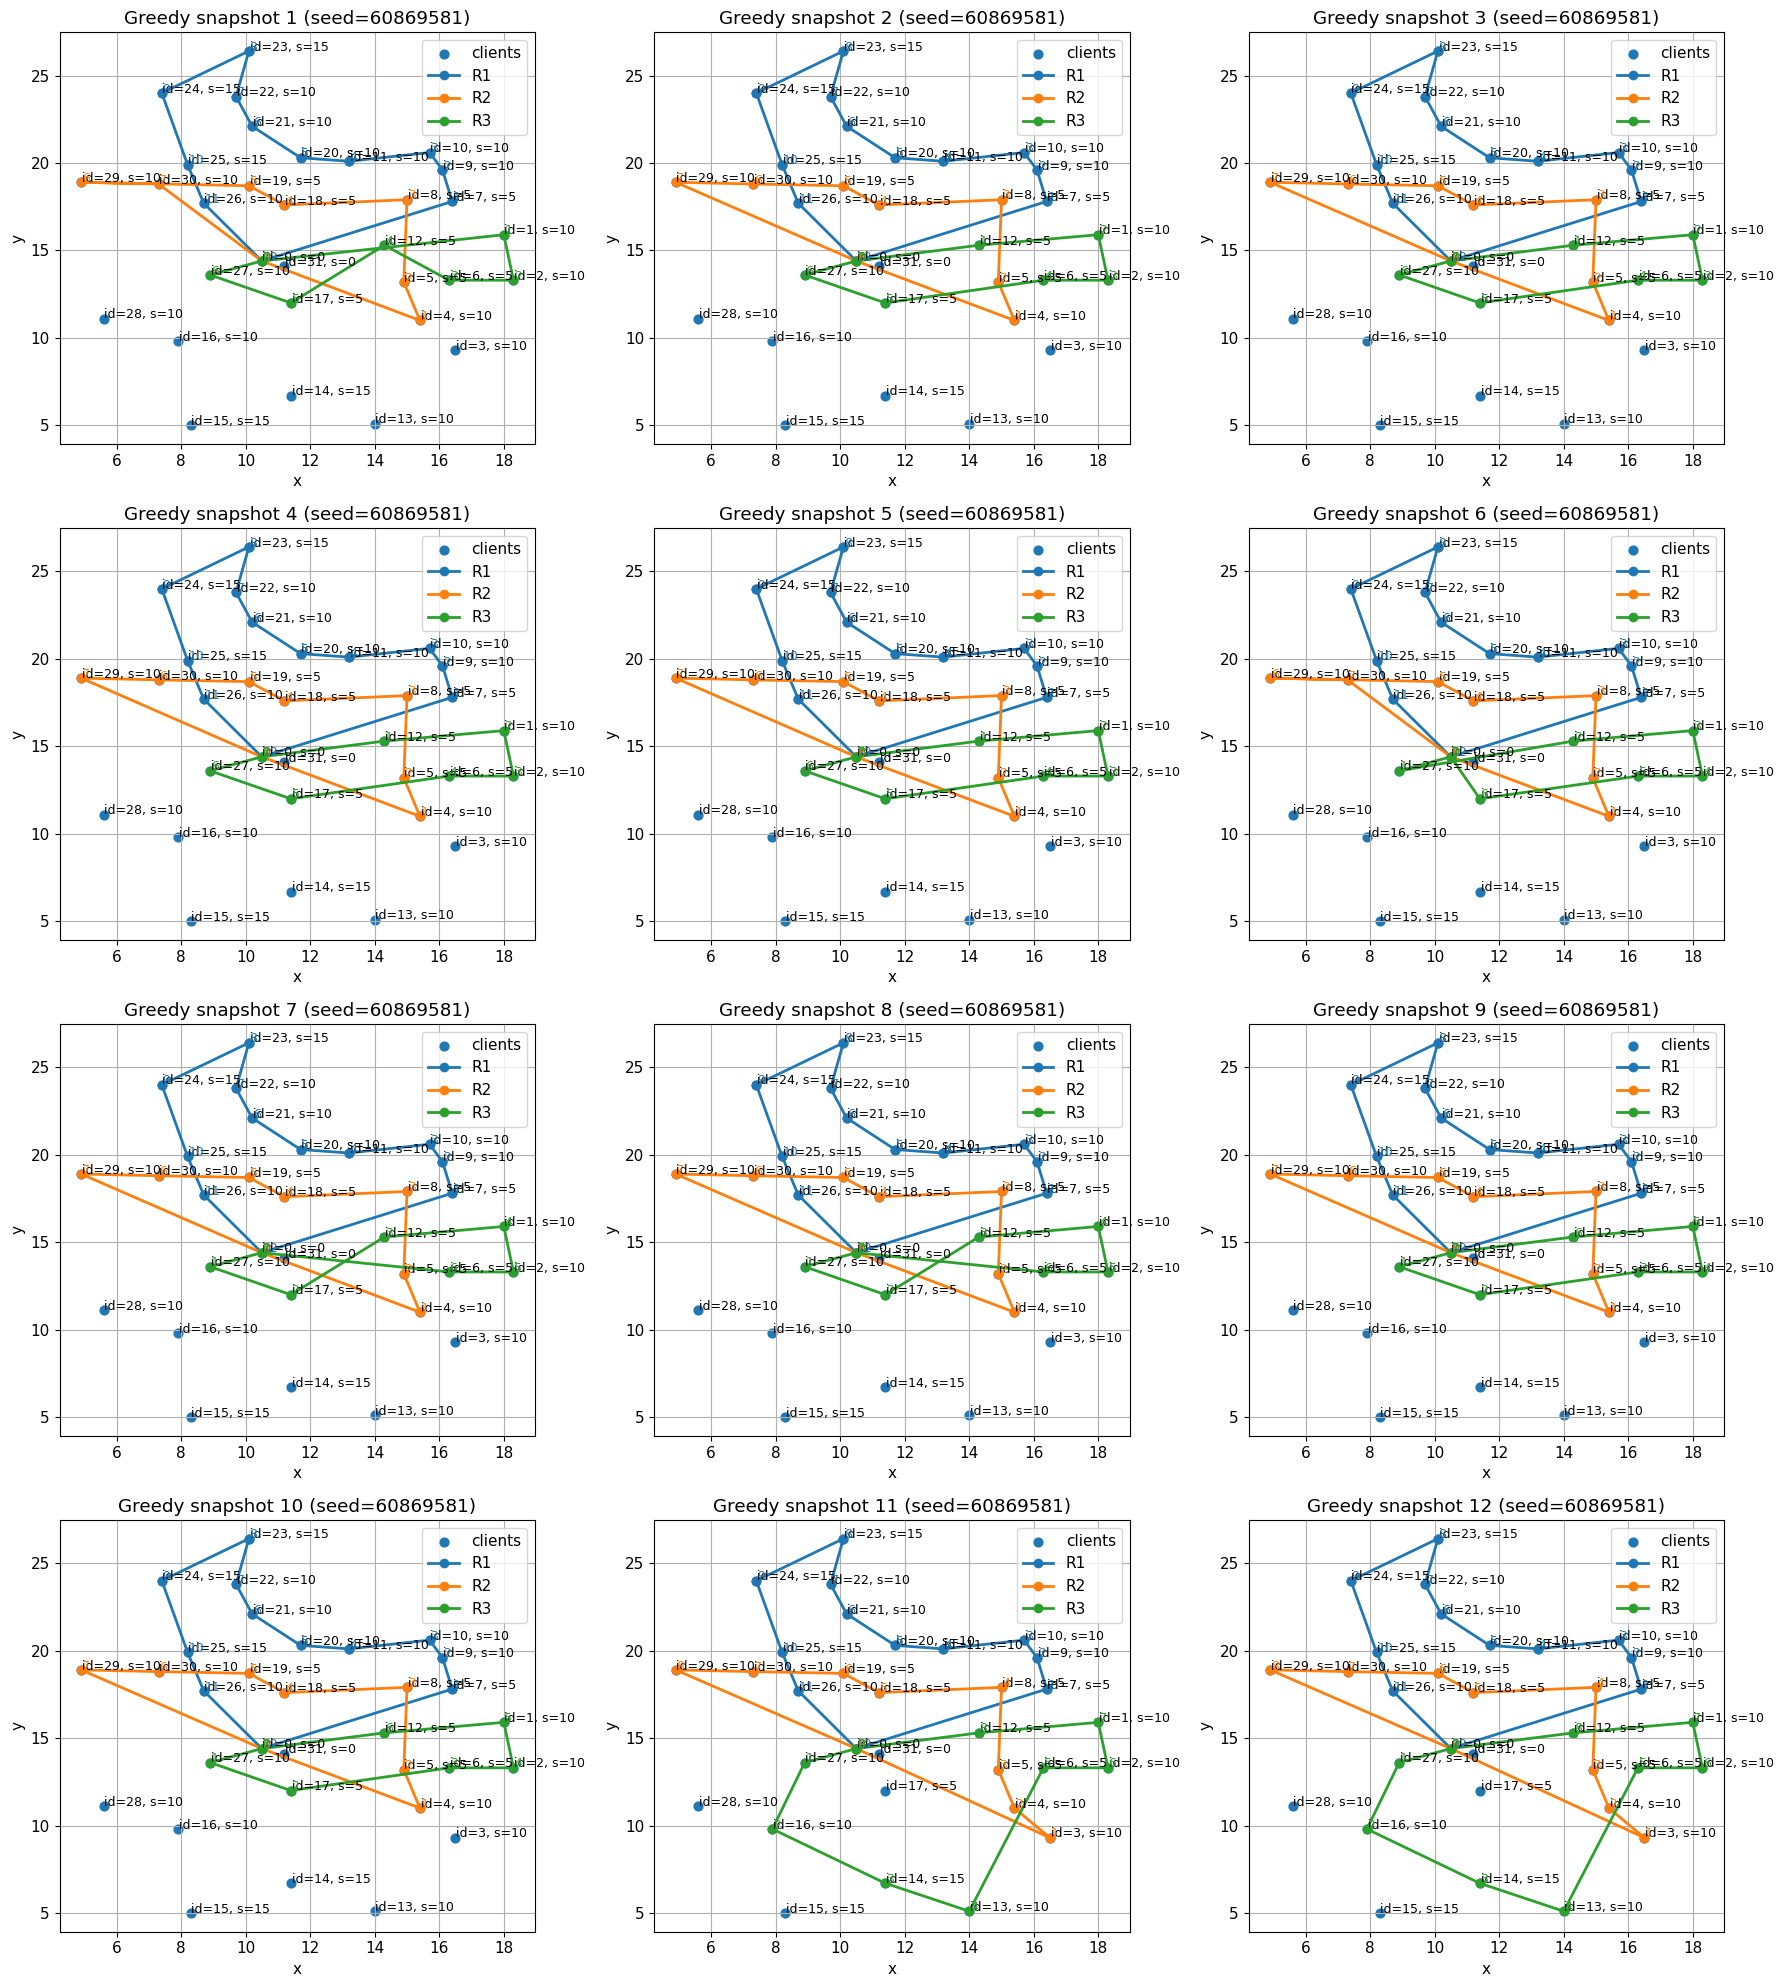

In [9]:
# dist_matrix est calculée automatiquement dans Probleme.__post_init__
seed = random.randrange(1 << 30)
# snapshots = [polar_sweep_routes(prob)]
snapshots = [clarke_wright_marguerite(prob)]
routes = snapshots[-1]

print('Initial scores: ', [r.total_score for r in routes], '=', sum(r.total_score for r in routes))

# Après construction, appliquer les améliorations locales et inter-routes
for improvement in (
    lambda x: two_opt_each_routes(x, max_iter=500),
    lambda x: swap_between_routes(x),
    lambda x: or_opt_between_routes(x, k=2),
    lambda x: cross_exchange(x),
    lambda x: or_opt_within_routes(x, max_k=3),
    lambda x: relocate_within_routes(x),
    lambda x: relocate_between_routes(x),
    lambda x: iterated_local_search(x, max_iter=3),
):
    routes = improvement(routes)
    snapshots.append(routes.copy())

for improvement in (
    lambda x: improve_travel_time(x),
    lambda x: expand_with_unvisited(x, max_insertions=50, reopt_each_insert=True),
    lambda x: iterated_local_search_expanding(x, outer_iters=3, verbose=True),
):
    routes = improvement(routes)
    snapshots.append(_deepcopy_routes(routes))
    print('Intermediate scores: ', [r.total_score for r in routes], '=', sum(r.total_score for r in routes))

print('seed =', seed)

# Plot snapshots in a 3 x N grid
cols = 3
n_snap = len(snapshots)
if n_snap > 0:
    rows = math.ceil(n_snap / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
    axs_flat = axs.flatten() if hasattr(axs, 'flatten') else [axs]
    for i, s in enumerate(snapshots):
        ax = axs_flat[i]
        prob.plot(ax=ax, title=f'Greedy snapshot {i+1} (seed={seed})')
        for j, r in enumerate(s):
            r.plot(ax=ax, color=f'C{j%10}', label=f'R{j+1}')
        ax.legend()
    for k in range(n_snap, rows*cols):
        axs_flat[k].axis('off')
    plt.tight_layout()
    plt.show()
else:
    print('No snapshots to display')

# Bornes du Problème

In [10]:
def upper_bound_relaxe(prob):
    import numpy as np
    s, a, n, m, L = prob.start, prob.end, prob.n, prob.m, prob.L
    scores = prob.points['score'].to_numpy()

    # Fallback trivial si SciPy absent
    try:
        from scipy.optimize import linprog
    except Exception:
        UB_triv = int(scores.sum() - scores[s] - scores[a])
        return float(UB_triv), {"methode": "trivial"}

    # Arcs autorisés: i!=j, pas d'arcs vers s, pas d'arcs depuis a
    M = np.ones((n, n), dtype=bool)
    np.fill_diagonal(M, False)
    M[:, s] = False
    M[a, :] = False
    I, J = np.where(M)
    A = len(I)  # nb d'arcs

    # Variables: x_ij (A vars) + y_i (n vars)
    c = np.zeros(A + n)
    c[A:] = -scores
    c[A + s] = c[A + a] = 0.0  # dépôts non récompensés
    bounds = [(0, 1)] * (A + n)

    # Budget: sum d(i,j) x_ij <= m L
    A_ub = np.zeros((1, A + n))
    A_ub[0, :A] = prob.dist_matrix[I, J]
    b_ub = np.array([m * L], dtype=float)

    # Égalités: pour i ∈ clients: sum_j x_ij - y_i = 0 et sum_j x_ji - y_i = 0
    rows = []
    rhs = []
    for i in range(n):
        if i in (s, a): 
            continue
        row = np.zeros(A + n); row[np.where(I == i)[0]] = 1.0; row[A + i] = -1.0
        rows.append(row); rhs.append(0.0)
        row = np.zeros(A + n); row[np.where(J == i)[0]] = 1.0; row[A + i] = -1.0
        rows.append(row); rhs.append(0.0)
    # Degré de s et a (m départs et m arrivées)
    row = np.zeros(A + n); row[np.where(I == s)[0]] = 1.0; rows.append(row); rhs.append(float(m))
    row = np.zeros(A + n); row[np.where(J == a)[0]] = 1.0; rows.append(row); rhs.append(float(m))

    A_eq = np.vstack(rows) if rows else None
    b_eq = np.array(rhs) if rows else None

    res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")
    if not res.success:
        UB_triv = int(scores.sum() - scores[s] - scores[a])
        return float(UB_triv), {"methode": "trivial", "raison": res.message}

    UB = float(-res.fun)
    UB_triv = float(scores.sum() - scores[s] - scores[a])
    return min(UB, UB_triv), {"methode": "relaxation_LP", "status": res.status, "message": res.message}

UB, info = upper_bound_relaxe(prob)
print("UB ≈", round(UB, 2), info)

UB ≈ 285.0 {'methode': 'trivial'}


# Solution Heuristique à comparer

In [ ]:
# ================================
# Cellule finale : Boucle heuristique complète
# ================================
# Idée générale :
# 1) Construction initiale (diversification) : randomized_greedy_routes
# 2) Compression (réduction des distances) : 2-opt / Or-Opt / relocate / swap / cross-exchange...
# 3) Extension (ajouts/remplacements) : inserer des non-visités tant que le budget le permet
# 4) ILS (itérations compression→extension) : intensifier tant que le score augmente
# 5) Arrêt si le score n’augmente plus (borne de terminaison claire)

def _total_score(routes):
    return sum(r.total_score for r in routes)

def _deepcopy_routes(routes):
    # Fige l'état de chaque route (copie profonde de stops + recalc des métriques)
    return [Route(list(r.stops), r.probleme) for r in routes]

def improve_travel_time(routes):
    """
    Phase 'compression' : on réduit la distance sans changer l'ensemble de clients.
    - intra-route (2-opt, or-opt, relocate)
    - inter-routes (swap, or-opt inter, cross-exchange, relocate)
    Objectif : libérer du budget pour rendre possibles des insertions ensuite.
    """
    routes = two_opt_each_routes(routes, max_iter=300)
    routes = or_opt_within_routes(routes, max_k=3)
    routes = relocate_within_routes(routes)

    # Inter-routes : permet de débloquer des structures et libérer encore du budget
    routes = swap_between_routes(routes)
    routes = or_opt_between_routes(routes, k=2)
    routes = cross_exchange(routes)
    routes = relocate_between_routes(routes)
    return routes

def expand_with_unvisited(routes, max_insertions=50, reopt_each_insert=True):
    """
    Phase 'extension' : on tente d'ajouter autant de non-visités que possible.
    1) Chaîne d'insertions gloutonnes (insert_unvisited_into_routes).
       Option : re-optimiser légèrement après chaque insertion (2-opt) pour regagner du budget.
    2) Si bloqué en insertion, tenter des remplacements (replace_node_with_unvisited) pour augmenter le score.
    """
    inserted = 0
    while inserted < max_insertions:
        new_routes = insert_unvisited_into_routes(routes)
        if new_routes is routes:  # aucune insertion possible (le code renvoie la même liste si pas de move)
            break
        routes = new_routes
        inserted += 1
        if reopt_each_insert:
            routes = two_opt_each_routes(routes, max_iter=150)  # re-compression rapide

    # Remplacement si plus d'insertion possible et si cela augmente le score
    prev_score = _total_score(routes)
    replaced = replace_node_with_unvisited(routes)
    if _total_score(replaced) > prev_score:
        routes = replaced

    return routes

def iterated_local_search_expanding(routes, outer_iters=3, verbose=False):
    """
    ILS avec extension :
    - Répète 'compression' -> 'extension' plusieurs fois
    - Arrête si le score n'augmente plus
    """
    current = _deepcopy_routes(routes)
    for it in range(1, outer_iters + 1):
        prev_score = _total_score(current)
        current = improve_travel_time(current)
        current = expand_with_unvisited(current, max_insertions=50, reopt_each_insert=True)
        now_score = _total_score(current)
        if verbose:
            print(f"[ILS+Expand] it={it} score={now_score} (Δ={now_score - prev_score})")
        if now_score <= prev_score + 1e-9:
            break
    return current

# --- Outils de résumé/évaluation pour l'affichage ---

def evaluate(routes):
    sc = sum(r.total_score for r in routes)
    dist = sum(r.total_distance for r in routes)
    feas = all(r.total_distance <= r.probleme.L + 1e-9 for r in routes)
    return sc, dist, feas

def print_solution_summary(tag, routes):
    sc, dist, feas = evaluate(routes)
    per_scores = [r.total_score for r in routes]
    per_dists = [round(r.total_distance, 4) for r in routes]
    print(tag)
    print(f"  Scores per route: {per_scores}  => total = {sc}")
    print(f"  Dists per route: {per_dists}  => total = {dist:.4f}  (budget max = {routes[0].probleme.m * routes[0].probleme.L:.4f})")
    print(f"  Feasible (all routes <= L): {feas}")
    return sc, dist, feas

# --- Boucle heuristique finale (commentée) ---

def heuristic_loop(prob, seed=42, alpha=0.30, restarts=10, outer_ils=3):
    """
    Construction + améliorations :
    - Construction initiale (GRASP) : randomized_greedy_routes (diversifie avec alpha et restarts)
    - Compression : réduit distances pour libérer du budget
    - Extension : insère/remplace des non-visités quand possible
    - ILS+Extension : répète compression→extension quelques tours (outer_ils) pour intensifier
    - Arrêt : si le score n'augmente plus entre deux rounds globaux

    Remarque : Le score peut rester constant si
    - tous les clients sont déjà visités,
    - la slack (L - distance) est insuffisante pour insérer un client supplémentaire,
    - les non-visités restants ont des scores trop faibles pour un remplacement gagnant,
    - ou s'il existe des contraintes géométriques défavorables (delta d'insertion trop élevé).
    """
    # 1) Construction initiale (meilleur des 'restarts' via randomized_greedy_routes)
    routes = randomized_greedy_routes(prob, alpha=alpha, seed=seed, restarts=restarts)
    print_solution_summary("Initial randomized greedy (best of restarts)", routes)

    # 2) Rounds globaux : compression -> extension -> ILS+extension
    prev_score = -1
    round_idx = 0
    while True:
        round_idx += 1

        # Compression (libère du budget)
        routes = improve_travel_time(routes)

        # Extension (exploite le budget pour ajouter/remplacer des clients)
        routes = expand_with_unvisited(routes, max_insertions=100, reopt_each_insert=True)

        # ILS + extension (intensification)
        routes = iterated_local_search_expanding(routes, outer_iters=outer_ils, verbose=False)

        now_score, _, _ = evaluate(routes)
        print_solution_summary(f"After improvement round {round_idx}", routes)

        if now_score <= prev_score + 1e-9:
            break  # arrêt si pas d'amélioration de score
        prev_score = now_score

    return routes

# --- Exécution de la boucle heuristique et comparaison aux bornes ---

final_routes = heuristic_loop(prob, seed=42, alpha=0.30, restarts=10, outer_ils=3)
final_score, final_dist, final_feas = evaluate(final_routes)

# Choix de la borne supérieure (UB) à afficher :
# - Si UB_lp/info_lp/UB_triv existent (calculés dans la cellule "Bornes du Problème") on les réutilise.
# - Sinon, si upper_bound_relaxe(prob) est défini, on l'emploie.
# - Sinon, repli sur la somme des scores clients (borne triviale).
try:
    UB_affichee = UB_lp if info_lp.get("methode") == "relaxation_LP" else UB_triv
except Exception:
    try:
        UB_affichee, _ = upper_bound_relaxe(prob)  # si vous avez ajouté la version compacte
    except Exception:
        s, a = prob.start, prob.end
        all_scores = prob.points['score'].astype(float).to_numpy()
        UB_affichee = float(all_scores.sum() - all_scores[s] - all_scores[a])

gap = (UB_affichee - final_score) / max(UB_affichee, 1e-9) * 100.0

print("\nComparison with bounds")
print(f"  Final heuristic score = {final_score}")
print(f"  Upper bound (UB) ≈ {UB_affichee:.2f}")
print(f"  Relative gap to UB ≈ {gap:.2f}%")

Initial randomized greedy (best of restarts)
  Scores per route: [70, 95, 70]  => total = 235
  Dists per route: [34.7871, 34.0372, 33.2472]  => total = 102.0715  (budget max = 105.0000)
  Feasible (all routes <= L): True
After improvement round 1
  Scores per route: [90, 110, 75]  => total = 275
  Dists per route: [33.589, 33.5333, 33.0305]  => total = 100.1528  (budget max = 105.0000)
  Feasible (all routes <= L): True


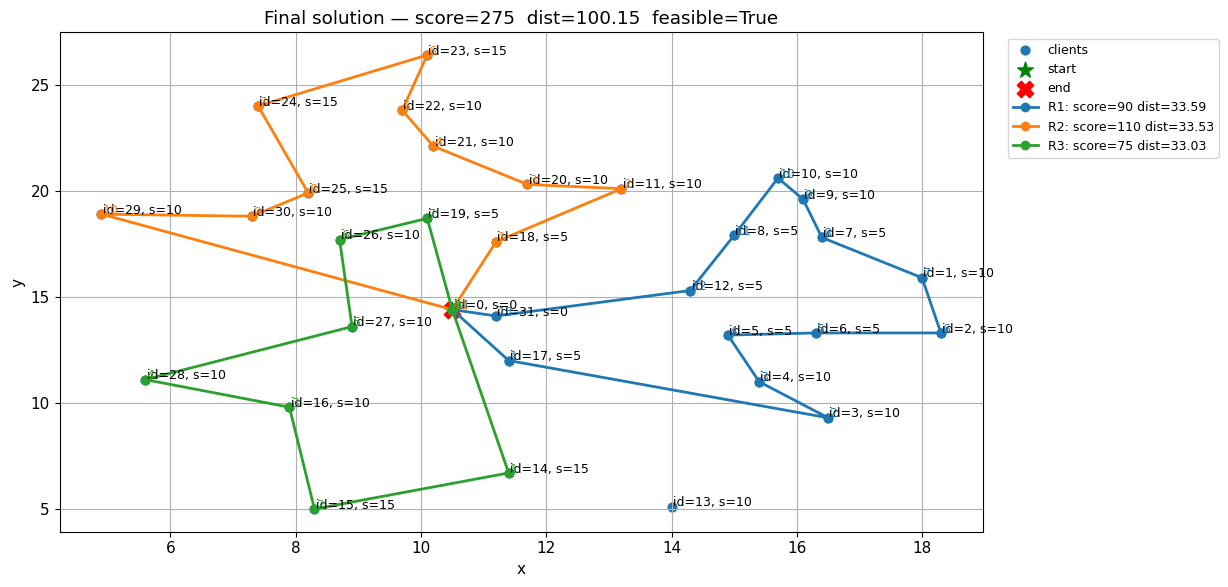

In [ ]:
# Plot the final route
import matplotlib.pyplot as plt

# Ensure final_routes and prob exist in the notebook namespace
try:
    routes_to_plot = final_routes
    problem = prob
except NameError:
    raise RuntimeError('final_routes or prob not found. Run earlier cells to produce final_routes and prob.')

# Compute summary
total_score = sum(r.total_score for r in routes_to_plot)
total_dist = sum(r.total_distance for r in routes_to_plot)
feasible = all(r.total_distance <= r.probleme.L + 1e-9 for r in routes_to_plot)

fig, ax = plt.subplots(figsize=(16, 6))
# Plot base points (clients, annotated) using existing method
problem.plot(ax=ax, title=f'Final solution — score={total_score}  dist={total_dist:.2f}  feasible={feasible}')

# Highlight start and end
srow = problem.points.loc[problem.start]
erow = problem.points.loc[problem.end]
ax.scatter([srow['x']], [srow['y']], c='green', s=140, marker='*', label='start')
ax.scatter([erow['x']], [erow['y']], c='red', s=140, marker='X', label='end')

# Plot each route with distinct color and label including score/distance
for idx, r in enumerate(routes_to_plot):
    color = f'C{idx % 10}'
    label = f'R{idx+1}: score={r.total_score} dist={r.total_distance:.2f}'
    r.plot(ax=ax, color=color, label=label)

# Improve legend layout
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=9, loc='upper left', bbox_to_anchor=(1.02, 1))

plt.tight_layout(rect=(0,0,0.78,1))
plt.show()